https://github.com/rasbt/machine-learning-book/blob/main/ch18/ch18_part2.py

In [ ]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cpu.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cpu.html


In [ ]:
import utils
import torch
from pandas import read_csv, DataFrame as df
from numpy import array as arr, expand_dims, arange, corrcoef as corr, where, isnan
from ast import literal_eval as lev
from sklearn.model_selection import train_test_split as tts
from warnings import filterwarnings as fw; fw("ignore")
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import NNConv, global_add_pool
import math
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

In [ ]:
RANDOM_SEED = 42
EMBEDDING_DIM = 5
BATCH_SIZE = 2

In [ ]:
THRESHOLD = .95
WINDOW_SIZE = 40

In [ ]:
DATASET_PATH = "./dataset/"

In [ ]:
def load_dataset(path : str = DATASET_PATH, partial : int = None, *args, **kwargs) -> tuple:
    big_dataset = read_csv(path + "gp_table.csv")
    
    if partial is not None:
        big_dataset = big_dataset[:partial]
    
    x = arr([lev(i) for i in big_dataset['snps']]) # convert string of list into literal list
    y = arr(big_dataset['rice_yield'])
    print("============ Raw Data ============")
    print("x data dim: {}".format(x.shape))
    print("y data dim: {}".format(y.shape), end="\n\n")

    # split dataset
    x_train, x_test, y_train, y_test = tts(x, y, test_size=.3, random_state=RANDOM_SEED)
    x_test, x_val, y_test, y_val = tts(x_test, y_test, test_size=.5, random_state=RANDOM_SEED)

    print("========= Processed Data =========")
    print("x_train: {}, y_train: {}".format(len(x_train), len(y_train)))
    print("x_valid: {}, y_valid: {}".format(len(x_val), len(y_val)))
    print("x_test: {}, y_test: {}".format(len(x_test), len(y_test)))

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

In [ ]:
def chr_pos_list(path : str = DATASET_PATH, *args, **kwargs) -> dict:
    imputed_snps_data = read_csv(path + "ind-rg-snps.csv")
    cleaned_snps = df(imputed_snps_data.columns[2:], columns=["snps"])
    
    chr_data = read_csv(path + "ind-rg-chrpos.csv", index_col=0)
    chr_data.insert(len(chr_data.columns), "snps", list(map(lambda x, y: x + "_" + y, chr_data.id, chr_data.ref)))
    
    snps_chrpos = chr_data.merge(cleaned_snps, on=["snps"], how="right")
    all_chr_list = torch.tensor(snps_chrpos.chr.values, dtype=torch.long)
    all_pos_list = torch.tensor(snps_chrpos.pos.values, dtype=torch.long)
    return {"chr" : all_chr_list, "pos" : all_pos_list}

In [ ]:
snps_chr_pos = chr_pos_list()
all_chr_list, all_pos_list = snps_chr_pos["chr"], snps_chr_pos["pos"]

In [ ]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_dataset(partial=100, apply_pca=True)

============ Raw Data ============
x data dim: (100, 1232)
y data dim: (100,)

========= Processed Data =========
x_train: 70, y_train: 70
x_valid: 15, y_valid: 15
x_test: 15, y_test: 15


In [ ]:
def vectorized_sliding_windows(data, max_len : int, window_size : int = WINDOW_SIZE, start : int = 0) -> arr:
    max_len -= window_size-1
    sub_windows = (
        start +
        expand_dims(arange(window_size), 0) +
        expand_dims(arange(max_len), 0).T
    )
    
    return arr(data)[sub_windows]

In [ ]:
def create_edge_index(
    data,
    thresh : float = THRESHOLD,
    step_decay : float = .02,
    lower_bound_edges : int = 20,
    *args, **kwargs
) -> dict:
    edges = []
    count_step_decay = 0
    corr_vals= []
    
    while len(edges) <= lower_bound_edges:
        corr_vals= []
        allel = df(corr(vectorized_sliding_windows(data, len(data))))
        allel = allel.mask(allel < thresh) # filter: mark column as NaN if it is below the threshold
        
        edges = [(x, allel.columns[y]) for x, y in zip(*where(~isnan(allel.values)))] # get coord where the value is not NaN
        edges = [i for i in edges if i[0] != i[1]] # remove duplicates (in diagonal), e.g., (0, 0), (1, 1), (2, 2)

        
        # corr_vals = [x for x in math.isnan(allel.values)]
        for i in range(0, len(allel.values)):
          for j in range(0, len(allel.values[i])):
            if i!=j and math.isnan(allel.values[i][j]) == False:
              corr_vals.append(allel.values[i][j])

        # corr_vals = [i for i in corr_vals if i[0] != i[1]]      

        if len(edges) <= lower_bound_edges:
            thresh = round(thresh-step_decay, 2)
            count_step_decay += 1

    # print(corr_vals)
    # print(edges)
    # print(len(corr_vals))
    # print(len(edges))
    idx_source, idx_dest = [idx[0] for idx in edges], [idx[1] for idx in edges]
    # print(len(idx_source))
    edge_index = torch.tensor([idx_source, idx_dest], dtype=torch.long)
    return {"edge_index" : edge_index, "corr_vals": corr_vals, "total_conn" : len(edges), "treshold_used" : thresh, "count_step_decay" : count_step_decay}

In [ ]:
def create_node_index(
    snp_data,
    snp_vocab : int = 3,
    chr_data : torch.Tensor = all_chr_list,
    chr_vocab : int = max(all_chr_list).item()+1,
    pos_data : torch.Tensor = all_pos_list,
    pos_vocab : int = max(all_pos_list).item()+1,
    dim : int = EMBEDDING_DIM,
    *args, **kwargs
) -> dict:
    embedding = torch.nn.Embedding(3, dim)
    node_index = embedding(torch.from_numpy(snp_data))
    
    chr_embedding = torch.nn.Embedding(chr_vocab, dim)
    node_index += chr_embedding(chr_data)
    
    pos_embedding = torch.nn.Embedding(pos_vocab, dim)
    node_index += pos_embedding(pos_data)
    return {"node_index" : node_index, "shape" : node_index.shape}

In [ ]:
def create_edge_attr(
    corr_vals,
    *args, **kwargs
) -> dict:

    cor_val_labels = []
    for val in corr_vals:
      if val == 0: 
        # print(f'{val} No Correlation')
        cor_val_labels.append(0)
      elif val <0.6:
        # print(f'{val} Less Correlation')
        cor_val_labels.append(1)
      elif val < 1:
        # print(f'{val} Correlated')
        cor_val_labels.append(2)
      else:
        # print(f'{val} Highly Correlated')
        cor_val_labels.append(3)   

    cor_val_labels = torch.tensor(cor_val_labels)
    edge_attribute = F.one_hot(cor_val_labels, num_classes=4).to(torch.float)

    return {"edge_attribute" : edge_attribute, "shape" : edge_attribute.shape}

In [ ]:
def create_dataloader(x, label, batch_size : int = BATCH_SIZE, *args, **kwargs):
    data = []
    for i in zip(x, label):
        snp_data, yield_data = i[0], i[1]
        node = create_node_index(snp_data)
        edge = create_edge_index(snp_data)
        # print(edge["corr_vals"])
        edge_attribute = create_edge_attr(edge["corr_vals"])
        label = torch.tensor(i[1], dtype=torch.long)
        data.append(Data(x=node["node_index"], edge_index=edge["edge_index"], y=label, edge_attr= edge_attribute["edge_attribute"] ))
        
        del snp_data
        del yield_data
        del node
        del edge
        del label
        
    return DataLoader(data, batch_size=batch_size, shuffle=True)

In [ ]:
# valid_dataloader = create_dataloader(x_val[:1], y_val[:1])

In [ ]:
train_dataloader = create_dataloader(x_train[:3], y_train[:3])
valid_dataloader = create_dataloader(x_val[:1], y_val[:1])
test_dataloader = create_dataloader(x_test[:1], y_test[:1])

In [ ]:
# print(test_dataloader)
for data in test_dataloader:
  print(data.y)

tensor([3])


In [ ]:
print("train")
for i in train_dataloader:
    print(i)
print()
print("valid")
for i in valid_dataloader:
    print(i)
print()
print("test")
for i in test_dataloader:
    print(i)

train
DataBatch(x=[2464, 5], edge_index=[2, 88], edge_attr=[88, 4], y=[2], batch=[2464], ptr=[3])
DataBatch(x=[1232, 5], edge_index=[2, 26], edge_attr=[26, 4], y=[1], batch=[1232], ptr=[2])

valid
DataBatch(x=[1232, 5], edge_index=[2, 52], edge_attr=[52, 4], y=[1], batch=[1232], ptr=[2])

test
DataBatch(x=[1232, 5], edge_index=[2, 32], edge_attr=[32, 4], y=[1], batch=[1232], ptr=[2])


In [ ]:
class ExampleNet(torch.nn.Module):
    def __init__(self,num_node_features, num_edge_features):
        super().__init__()
        conv1_net = nn.Sequential(nn.Linear(num_edge_features, 32),
                                  nn.ReLU(),
                                  nn.Linear(32, num_node_features*32))
        conv2_net = nn.Sequential(nn.Linear(num_edge_features,32),
                                  nn.ReLU(),
                                  nn.Linear(32, 32*16))
        self.conv1 = NNConv(num_node_features, 32, conv1_net)
        self.conv2 = NNConv(32, 16, conv2_net)
        self.fc_1 = nn.Linear(16, 32)
        self.out = nn.Linear(32, 1)
        
    def forward(self, data):
        batch, x, edge_index, edge_attr=data.batch, data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = global_add_pool(x,batch)
        x = F.relu(self.fc_1(x))
        output = self.out(x)
        return output

In [ ]:
num_node_feats, num_edge_feats = 5, 4
epochs = 4
net = ExampleNet(num_node_feats, num_edge_feats)

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
epochs = 4
target_idx = 1 # index position of the polarizability label

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
net.to(device)

import numpy as np

for total_epochs in range(epochs):
    epoch_loss = 0
    total_graphs = 0
    net.train()
    for batch in train_dataloader:
        batch.to(device)
        optimizer.zero_grad()
        output = net(batch)
        # print(type(output))
        # print(type(batch.y))
        loss = F.mse_loss(output, batch.y)

        loss_float = torch.tensor(loss, dtype=torch.float, requires_grad = True)
        loss_float.retain_grad()
        loss_float.backward()
        epoch_loss += loss.item()
        total_graphs += batch.num_graphs
        optimizer.step()
    
    train_avg_loss = epoch_loss / total_graphs
    val_loss = 0
    total_graphs = 0
    net.eval()
    for batch in valid_dataloader:
        batch.to(device)
        output = net(batch)
        loss = F.mse_loss(output,batch.y)
        val_loss += loss.item()
        total_graphs += batch.num_graphs
    val_avg_loss = val_loss / total_graphs
    
    
    print(f"Epochs: {total_epochs} | epoch avg. loss: {train_avg_loss:.2f} | validation avg. loss: {val_avg_loss:.2f}")
    print()

Epochs: 0 | epoch avg. loss: 2843.52 | validation avg. loss: 4732.28

Epochs: 1 | epoch avg. loss: 2843.52 | validation avg. loss: 4732.29

Epochs: 2 | epoch avg. loss: 2843.52 | validation avg. loss: 4732.28

Epochs: 3 | epoch avg. loss: 3194.31 | validation avg. loss: 4732.28



In [ ]:
net.eval()
predictions = []
real = []

for batch in test_dataloader:
    print(batch.y)
    output = net(batch.to(device))
    predictions.append(output.detach().cpu().numpy())
    real.append(batch.y.detach().cpu().numpy())

predictions = np.concatenate(predictions)
real = np.concatenate(real)

tensor([3])


In [ ]:
print(len(predictions))
print(len(real))

1
1


Text(0.5, 0, 'Isotropic polarizability')

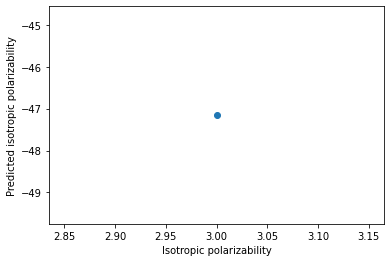

In [ ]:
plt.scatter(real,predictions)
plt.ylabel('Predicted isotropic polarizability')
plt.xlabel('Isotropic polarizability')

In [ ]:
del train_dataloader